# NASA Miscrosoft Rock Classification   <img src="images/nasa.png"  width="90" height="90" align="right"><img src="images/msft.jpg"  width="200" height="200" align="right">


### In this learning path, we will learn how to build an artifitially intelligent system to classify the rock images.
Here are some of 1000's of rock images NASA has proivided: 

Basalt rocks: <br>
<img src="images/Basalt_Cristobalite_s69-45569.jpg" width="200" align="center">
<img src="images/Basalt_Cristobalite_s69-45583.jpg" width="200" align="center">
<br>Crustal rocks:<br>
<img src="images/Crustal_Anorthosite_s72-18182.jpg" width="150" align="center">
<img src="images/Crustal_Anorthosite_s72-46804.jpg" width="200" align="center">


We should carefully look at the images for each rock type to learn how to classify a new rock that just arrived from Space. 

### What type of rock do you think this newly arrived rock is?<br>
<img src="images/Basalt_Cristobalite_s75-31692.jpg" width="200" align="center">

## Before we build an AI system to detect the rock types, lets see how we 'humans' do it. 
This is the likely process that our brain goes through to do this:

## Step 0:
> We have to collect as many rock images as possible
 - Fortunately Microsoft has a great relationship with Nasa and has provided us 1000's of rock images


## Step 1:
> Our brain first tries to extract patterns from each image, patterns such as:
 - Color combinations 
 - Sharp edges 
 - Circular patterns 
 - Texture of the rock
 - Size of the rock <br>
 <img src="images/features.png" width="350" align="right">
 
 Our brains subconsciously do all of these without us noticing. We call these 'Features' in AI. 

## Step 2:
> Next, we try to find the relationships between the fearures and rock types
  - In this step our brain tries to figure out what are the charactristics/features of each rock type
  - As a result of this, we will come up with some rules, for example : "Darker rocks are usually Crustals". "Basalt rocks have more dense textures", ...
  - We show these associations with links such as shown below:<br>
  <img src="images/links.png" width="350" align="right">

## Step 3:
> Given a new rock image, our brain extracts all of its charactristics we discussed above, and then uses the associations we made in the second step to decides what type of rock it is.  

<img src="images/dl.png" width="550" align="right">



# The job of an AI scientist is to teach machines to do the same 3 steps. 
### Below we will walk through each step for machines:

## Step 0:
> Import the image data and computer programs that help us process images
1. Import Libraries
2. Import data
3. Transform images to matrixes of numbers

## Step 1:
> Extract features out of images
1. We Explore the Rock Images
2. Extract features such as texture, size, color, and edges  
**Scientists decide on what features should be used based on their intuition**


## Step 2:
> Make associations between the image features and rock types
1. Build a deep learning network capable of keeping track of millions of associations 

## Step 3:
> Predict the rock type for a new rock
1. Given a new rock image we extract features out of it
2. We use the associations we have learned to decide what type of rock it is


# Lets Walk Through Each Step for Computers and AI

## Step 0: 
>Lets Import the Libraries we need

In [34]:
# this library is used for plotting 
import matplotlib.pyplot as plt
# this library is used for processing large numerical matrixes (images)
import numpy as np
# this library is used for training and processing deep learning AI models
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
# this library is used for processing images and manipulating them (crop, change size, etc.)
import torchvision
from torchvision import datasets, transforms, models
# this library is used for visualizing images 
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

> Next, We will read the rock images

### When reading the rock images, they come in different sizes (small, medium, large) images, we will also crop all images to transform them into same sizes (224*224 pixels)

In [35]:
# telling the machine what folder contains the image data 
data_dir = './data'

# function to read the data, crop and resize the images and then split it into test and train chunks
def load_split_train_test(datadir, valid_size = .2):
    # this line of code transforms the images 
    train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)
    return trainloader, testloader

# Using 20% of data for testingS
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['Basalt', 'Crustal']


Images will look like below after computers transform them into numbers

<img src="images/lincoln.jpeg" width="400" align="right">
->
<img src="images/pixels.png" width="500" align="right">

> Now that we read the images, Lets check out few of the them

In [36]:
#transform the new image into numbers and resize it
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                    ])

#function to randomly select a number of images
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels


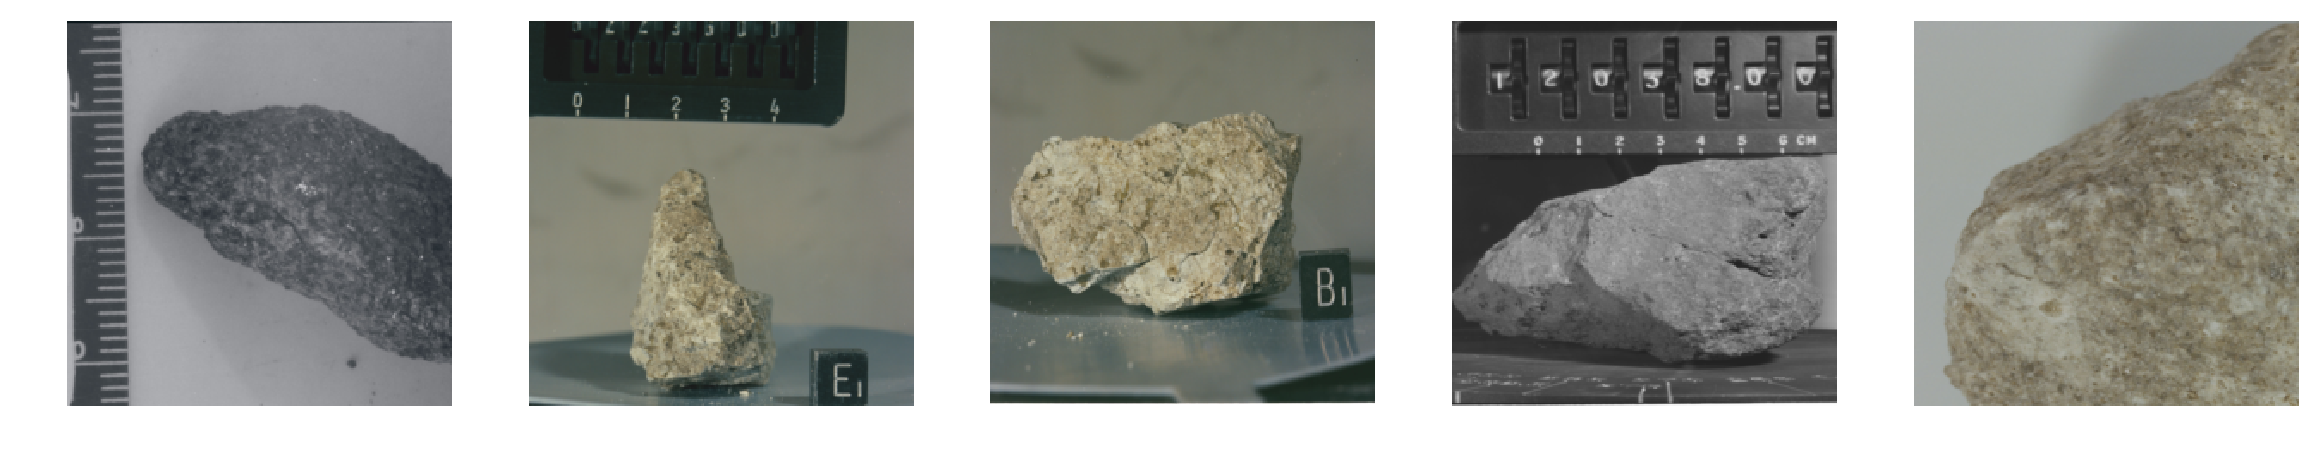

In [37]:
# how many images you want to see? set to 5 but can be changed 
images, labels = get_random_images(5)
to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))
classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Step 1:

## We have to extract features of images, this might be the most non intuitive step since our brains automatically extract features of images without us knowing. 

> We know each image is a collection of pixels and pixels can be represented with numbers 

> Therefore each image is a matrix of numbers

>To extract features out of images we multiply images by filters, each filter is responsoble for extracting a feature. 

Below you can see how we slide a filter over an image to extract features, such as edges, curves and texture of a rock

***We have so many of such filters, we will use 32 filters for our rock classification example.*** <br>

<img src="images/convv.gif" width="450" align="center">

## Step 2:

### Now Lets Build a neural network / deep network to learn the associations between features (curves, edges, texture, ...) and each rock type: 

In [38]:
# Determine if you are using a CPU or GPU for building the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


In [39]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Parameters of our deep learning model
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print('done')

done


### The Neural Network goes back and forth many times till it learns the best associations between features and rock types 

<img src="images/dl.gif" width="650" align="center">

## Training our deep learning model

In [40]:
# how many times do you want to back propagate to find the best associations, initial setting 10 but can be changed 
## increasing epochs will increase the accuracy most of the time but will take more time to build the neural network
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        
        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 3.592.. Test loss: 1.436.. Test accuracy: 0.552
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 1.330.. Test loss: 1.382.. Test accuracy: 0.456
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.685.. Test loss: 0.566.. Test accuracy: 0.746
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.578.. Test loss: 0.675.. Test accuracy: 0.456
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.572.. Test loss: 0.470.. Test accuracy: 0.842
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.517.. Test loss: 0.449.. Test accuracy: 0.842
Training step  31
Training step  32
T

## The accuracy of AI in classification of rocks is shown below: 

In [41]:
print(accuracy/len(testloader))

0.9020833373069763


## Potential way of imporoving the accuracy are:
1. Adding more images for training the AI models 
2. Increasing the epoch (number of training iterations for deep learning)

In [42]:
# lets save our neural network
torch.save(model, 'aerialmodel.pth')

## Step 3:

## Lets predict the rock types 

### To predict the type of a new rock image, we need to the following:
1. Convert the new image into numbers
2. Transform it (Crop and resize to 224*224)
3. Extract features and charactristics of the image
4. Predict its type using the associations we have learned in step 2.  

In [43]:
# Load the neural network we built in previous step
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')
#model.eval()

In [44]:
# function to predict the new image type
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

#### Lets pick 5 random images and see if our model can tell what type of rock it is:

In [45]:
# Set to 5 but can be adjusted to any number- for example if you want to test 10 rock images, use 10 in the code line below
images, labels = get_random_images(5)

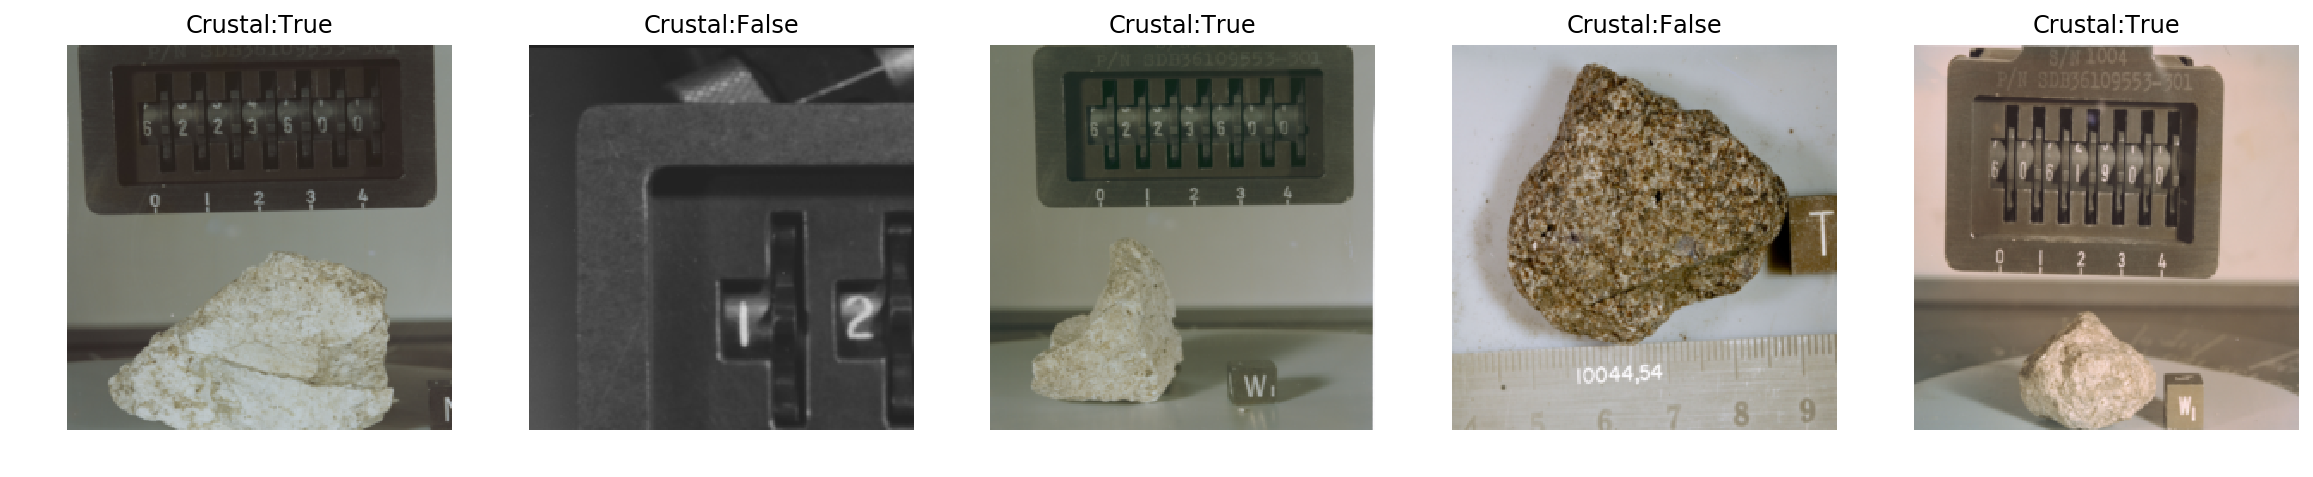

In [46]:
# code to visualize the new new images and add captions for image types
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))

classes=trainloader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

### The example images above are labeled as 

***Actual Rock Type : True / False ***

Where True and False show if our AI system correctly classified it or not.